In [49]:
pip install tensorflow


In [59]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load dataset
file_path = '/content/drive/MyDrive/DeepLearning/DataSet/TamilDatasetGrammar.xlsx'
df = pd.read_excel(file_path)

# Clean dataset
df = df.dropna(subset=['Original Sentence', 'Corrected Sentence'])
df['Original Sentence'] = df['Original Sentence'].astype(str)
df['Corrected Sentence'] = df['Corrected Sentence'].astype(str)

# Add start and end tokens for decoding
input_sentences = df['Original Sentence'].values
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in df['Corrected Sentence'].values]

# Tokenize input and target sentences
input_tokenizer = Tokenizer(filters='', oov_token='<unk>')
input_tokenizer.fit_on_texts(input_sentences)
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

output_tokenizer = Tokenizer(filters='', oov_token='<unk>')
output_tokenizer.fit_on_texts(target_sentences)
target_sequences = output_tokenizer.texts_to_sequences(target_sentences)

# Vocabulary sizes
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Maximum sequence lengths
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

# Decoder output data
decoder_output_data = np.zeros((len(target_sequences), max_target_length, output_vocab_size), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, word_id in enumerate(seq):
        if t > 0:  # Skip the first token
            decoder_output_data[i, t - 1, word_id] = 1.0

# Train-test split
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.2, random_state=42)


In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, encoder_outputs, decoder_hidden):
        # Calculate alignment scores
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden[:, tf.newaxis, :])))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [61]:
# Encoder Model for Inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder Model for Inference
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(output_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Decoding function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = output_tokenizer.index_word.get(sampled_token_index, '<unk>')
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()


Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - accuracy: 0.1688 - loss: 2.6726 - val_accuracy: 0.1755 - val_loss: 2.8554
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1721 - loss: 2.6091 - val_accuracy: 0.1837 - val_loss: 2.8608
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.1845 - loss: 2.5665 - val_accuracy: 0.1592 - val_loss: 2.8597
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.1648 - loss: 2.4772 - val_accuracy: 0.1837 - val_loss: 2.7888
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.1772 - loss: 2.4083 - val_accuracy: 0.2082 - val_loss: 2.7072
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.1839 - loss: 2.3887 - val_accuracy: 0.2082 - val_loss: 2.6731
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.1907 - loss: 2.3613 - val_accuracy: 0.1796 - val_loss: 2.6950
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.2062 - loss: 2.2541 - val_accuracy: 0.2082 - val_loss:

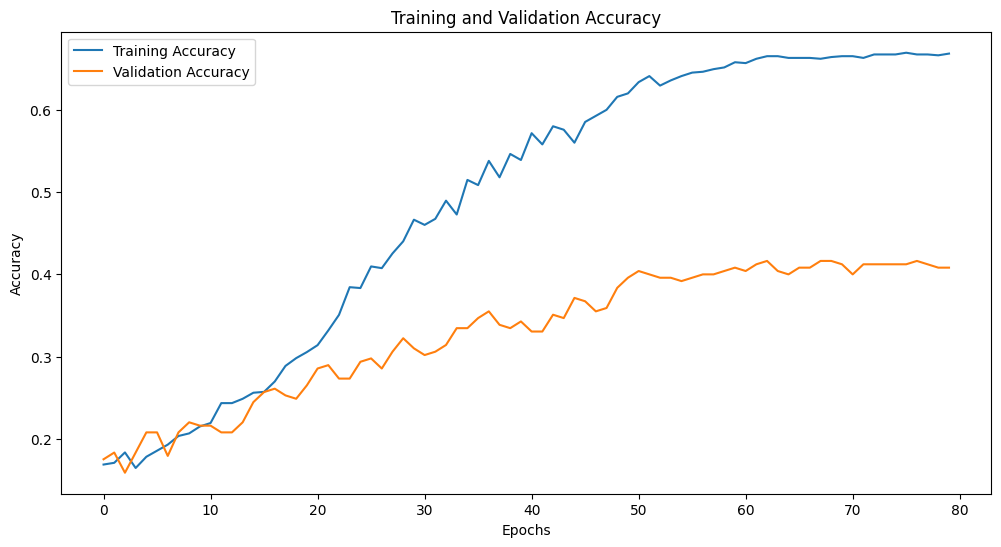

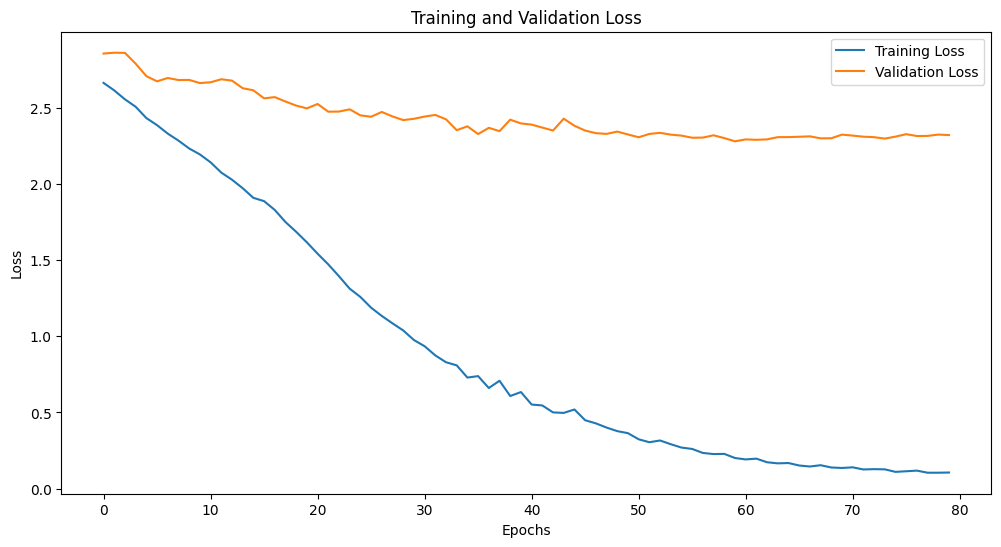

In [62]:
# Split data into training and validation sets
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.2, random_state=42)

# Train the model
batch_size = 64
epochs = 80

history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [65]:
# Encoder Model for Inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder Model for Inference
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(output_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Decode function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = output_tokenizer.index_word.get(sampled_token_index, '<unk>')
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()


In [66]:
# Random Sentence Testing and Accuracy
random_indices = random.sample(range(len(input_sentences)), 10)
total_bleu = 0
correct_predictions = 0

print("\n--- Random Sentence Testing ---\n")
for i in random_indices:
    original_sentence = input_sentences[i]
    correct_sentence = df['Corrected Sentence'].iloc[i]
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([original_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)

    bleu = sentence_bleu([correct_sentence.split()], predicted_sentence.split(), weights=(0.5, 0.5))
    total_bleu += bleu
    is_correct = predicted_sentence.strip() == correct_sentence.strip()
    correct_predictions += int(is_correct)

    print(f"Original: {original_sentence}")
    print(f"Predicted: {predicted_sentence}")
    print(f"Corrected: {correct_sentence}")
    print(f"Error Type: {'Incorrect Prediction' if not is_correct else 'Correct Prediction'}")
    print(f"BLEU Score: {bleu:.4f}\n")

# Calculate and display accuracy
accuracy = correct_predictions / len(random_indices)
average_bleu = total_bleu / len(random_indices)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average BLEU Score: {average_bleu:.4f}")



--- Random Sentence Testing ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original: அவளே கதையை கூறினான்.
Predicted: அவள் கதையை
Corrected: அவள் கதையை கூறினாள்.
Error Type: Incorrect Prediction
BLEU Score: 0.6065

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original: அவள் மகளை அழைத்தான்.
Predicted: அவள் மகளை அழைத்தாள்.
Corrected: அவள் மகளை அழைத்தாள்.
Error Type: Correct Prediction
BLEU Score: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original: பாடல்களை பாடினார் பாட்டு ஆசிரியர்.
Predicted: பாட்டு பாடல்களை பாடினார்.
Corrected: பாட்டு ஆசிரியர் பாடல்களை பாடினார்.
Error Type: Incorrec